## <center> Machine Learning Project
## <center> Course: ML1    
#### <center> Instructor: Dr. Tariq Mahmood

### <center> Submitted By:
## <center> Muhammad Uzair 29414
#### <center> MS - Data Science (IBA)
#### <center> Dataset - Customer Churn
https://archive.ics.uci.edu/dataset/563/iranian+churn+dataset

# Imports

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, auc, mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.class_weight import compute_class_weight
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from imblearn.over_sampling import SMOTE


# Functions

In [59]:
def load_data(filepath):
    df = pd.read_csv(filepath)
    return df

def class_label(df):
    # Assuming your dataset is stored in a variable called 'df'
    df['y'] = df['y'].replace({'yes': 1, 'no': 0})
    return df

def clean_data(df):
    df_cleaned = df.dropna()
    return df_cleaned

def transform_data(df):
    scaler = StandardScaler()
    numerical_cols = df.select_dtypes(include=['float64']).columns
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df
    
def eda(df):
    summary_stats = df.describe()
    float_cols = df.select_dtypes(include=['float64']).columns
    
    num_cols = len(float_cols)
    num_rows = (num_cols + 2) // 3
    
    plt.figure(figsize=(12, 8))
    for i, col in enumerate(float_cols):
        plt.subplot(num_rows, 3, i+1)
        sns.histplot(df[col], kde=True)
        plt.title(f'Histogram of {col}')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 8))
    for i, col in enumerate(float_cols):
        plt.subplot(num_rows, 3, i+1)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()


def manual_split(df, target_column):
    if isinstance(target_column, list):
        target_column = target_column[0]
    
    # One-hot encoding for categorical features
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    # Check if the target column is in the list of categorical columns
    if target_column in categorical_cols:
        # Remove the target column from the list of categorical columns
        categorical_cols.remove(target_column)
    # else:
    #     print(f"Target column '{target_column}' is not found in the DataFrame's categorical columns.")
    
    # Perform one-hot encoding excluding the target column
    df = pd.get_dummies(df, columns=categorical_cols)

    # Label encoding for the target variable
    label_encoder = LabelEncoder()
    df[target_column] = label_encoder.fit_transform(df[target_column])

    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=[target_column]),
        df[target_column],
        test_size=0.3,
        random_state=1
    )
    return X_train, X_test, y_train, y_test
    
def cv_scores(model,X_train, y_train):  
    # Example: KNN Classifier
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return cv_scores
    
def train_model(model,X_train,y_train):
    model.fit(X_train, y_train)

def evaluate_model(model,X_test,y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, output_dict=True)
    
    if len(np.unique(y_test)) > 2:
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
    else:
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    return accuracy, classification_rep, roc_auc

# without CI

## Master Pipeline

In [60]:
def master_pipeline(filepath, target):
    df = load_data(filepath)
    # df = class_label(df)
    df = clean_data(df)
    df = transform_data(df)
    # eda(df)
    X_train, X_test, y_train, y_test = manual_split(df, target)
    
    # Model selection
    model = model_selection()

    # Train model without cross-validation
    print("\nTraining model without cross-validation...")
    train_model(model, X_train, y_train)

    # Evaluate model without cross-validation
    print("\nEvaluating model without cross-validation...")
    acc_without_cv, class_rep_without_cv, roc_auc_without_cv = evaluate_model(model, X_test, y_test)

    print("\nResults without Cross-Validation:")
    print(f"F1 +ve: {class_rep_without_cv['1']['f1-score']:.3f}")
    print(f"F1 -ve: {class_rep_without_cv['0']['f1-score']:.3f}")
    print(f"AUC: {roc_auc_without_cv:.3f}")
    print(f"Accuracy: {acc_without_cv:.3f}")

    # Model selection with cross-validation
    print("\nTraining and evaluating model with cross-validation...")
    cv_scores_list = cv_scores(model, X_train, y_train)

    # Report cross-validation scores
    print("\nCross-Validation Scores:")
    for i, score in enumerate(cv_scores_list):
        print(f"Fold {i+1}: {score:.3f}")

    # Train model with all data
    print("\nTraining model with all data...")
    model.fit(X_train, y_train)

    # Evaluate model with all data
    print("\nEvaluating model with all data...")
    acc_with_all_data, class_rep_with_all_data, roc_auc_with_all_data = evaluate_model(model, X_test, y_test)

    print("\nResults with All Data:")
    print(f"F1 +ve: {class_rep_with_all_data['1']['f1-score']:.3f}")
    print(f"F1 -ve: {class_rep_with_all_data['0']['f1-score']:.3f}")
    print(f"AUC: {roc_auc_with_all_data:.3f}")
    print(f"Accuracy: {acc_with_all_data:.3f}")

In [61]:
# file path
filepath = 'Classification.Customer Churn.csv'
target = 'Churn'

df1 = pd.read_csv(filepath)



In [118]:
df1

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,21,0,19,2,6697,147,92,44,2,2,1,25,721.980,0
3146,17,0,17,1,9237,177,80,42,5,1,1,55,261.210,0
3147,13,0,18,4,3157,51,38,21,3,1,1,30,280.320,0
3148,7,0,11,2,4695,46,222,12,3,1,1,30,1077.640,0


In [119]:
df1.dtypes

Call  Failure                int64
Complains                    int64
Subscription  Length         int64
Charge  Amount               int64
Seconds of Use               int64
Frequency of use             int64
Frequency of SMS             int64
Distinct Called Numbers      int64
Age Group                    int64
Tariff Plan                  int64
Status                       int64
Age                          int64
Customer Value             float64
Churn                        int64
dtype: object

## Logistic Regression

In [64]:
def model_selection():
    model = LogisticRegression(max_iter = 1000000)
    print ('Logistic Regression')
    return model

In [65]:
master_pipeline(filepath, target)

Logistic Regression

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.525
F1 -ve: 0.937
AUC: 0.922
Accuracy: 0.889

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.900
Fold 2: 0.887
Fold 3: 0.882
Fold 4: 0.900
Fold 5: 0.905

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.525
F1 -ve: 0.937
AUC: 0.922
Accuracy: 0.889


## Naive Bayes

In [66]:
def model_selection():
    model = GaussianNB()
    print('Naive Bayes')
    return model

In [67]:
master_pipeline(filepath, target)

Naive Bayes

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.499
F1 -ve: 0.817
AUC: 0.897
Accuracy: 0.732

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.757
Fold 2: 0.744
Fold 3: 0.746
Fold 4: 0.746
Fold 5: 0.730

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.499
F1 -ve: 0.817
AUC: 0.897
Accuracy: 0.732


## Decision Tree

In [70]:
def model_selection():
    model = DecisionTreeClassifier()
    print('Decision Tree')
    return model

In [71]:
master_pipeline(filepath,target)

Decision Tree

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.782
F1 -ve: 0.964
AUC: 0.897
Accuracy: 0.938

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.959
Fold 2: 0.934
Fold 3: 0.939
Fold 4: 0.925
Fold 5: 0.930

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.777
F1 -ve: 0.962
AUC: 0.900
Accuracy: 0.935


## Random Forest Classifier

In [72]:
def model_selection():
    model = RandomForestClassifier()
    print('Random Forest Classifier')
    return model

In [73]:
master_pipeline(filepath, target)

Random Forest Classifier

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.801
F1 -ve: 0.967
AUC: 0.979
Accuracy: 0.944

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.966
Fold 2: 0.959
Fold 3: 0.955
Fold 4: 0.952
Fold 5: 0.955

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.797
F1 -ve: 0.967
AUC: 0.979
Accuracy: 0.944


## Gradient Boosting Classifier

In [74]:
def model_selection():
    model = GradientBoostingClassifier()
    print('Gradient Boosting Classifier')
    return model

In [75]:
master_pipeline(filepath, target)

Gradient Boosting Classifier

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.777
F1 -ve: 0.964
AUC: 0.972
Accuracy: 0.939

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.943
Fold 2: 0.948
Fold 3: 0.948
Fold 4: 0.952
Fold 5: 0.943

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.777
F1 -ve: 0.964
AUC: 0.972
Accuracy: 0.939


## Results

|          | Logistic Regression | Naïve Bayes | Decision Tree | Random Forest Classifier | Gradient Boosting |
|------------------------|---------------------|-------------|---------------|--------------------------|-------------------|
| F1 +ve                 | 0.525               | 0.499       | 0.777         | 0.797                    | 0.777             |
| F1-ve                  | 0.937               | 0.817       | 0.962         | 0.967                    | 0.964             |
| AUC                    | 0.922               | 0.897       | 0.900         | 0.979                    | 0.972             |
| Accuracy               | 0.889               | 0.732       | 0.935         | 0.944                    | 0.939             |


# =====================================================
# Class Imbalance - Resampling Method (Random Under Sampling)

## Master Pipeline

In [76]:
def master_pipeline_with_resampling(filepath, target):
    df = load_data(filepath)
    #df = class_label(df)
    df = clean_data(df)
    df = transform_data(df)
    # eda(df)
    
    # Apply Random Undersampling
    X_train, X_test, y_train, y_test = manual_split(df, target)
    rus = RandomUnderSampler(random_state=1)
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
    
    # Model selection
    model = model_selection()

    # Train model without cross-validation
    print("\nTraining model without cross-validation...")
    train_model(model, X_train_resampled, y_train_resampled)

    # Evaluate model without cross-validation
    print("\nEvaluating model without cross-validation...")
    acc_without_cv, class_rep_without_cv, roc_auc_without_cv = evaluate_model(model, X_test, y_test)

    print("\nResults without Cross-Validation:")
    print(f"F1 +ve: {class_rep_without_cv['1']['f1-score']:.3f}")
    print(f"F1 -ve: {class_rep_without_cv['0']['f1-score']:.3f}")
    print(f"AUC: {roc_auc_without_cv:.3f}")
    print(f"Accuracy: {acc_without_cv:.3f}")

    # Model selection with cross-validation
    print("\nTraining and evaluating model with cross-validation...")
    cv_scores_list = cv_scores(model, X_train_resampled, y_train_resampled)

    # Report cross-validation scores
    print("\nCross-Validation Scores:")
    for i, score in enumerate(cv_scores_list):
        print(f"Fold {i+1}: {score:.3f}")

    # Train model with all data
    print("\nTraining model with all data...")
    model.fit(X_train_resampled, y_train_resampled)

    # Evaluate model with all data
    print("\nEvaluating model with all data...")
    acc_with_all_data, class_rep_with_all_data, roc_auc_with_all_data = evaluate_model(model, X_test, y_test)

    print("\nResults with All Data:")
    print(f"F1 +ve: {class_rep_with_all_data['1']['f1-score']:.3f}")
    print(f"F1 -ve: {class_rep_with_all_data['0']['f1-score']:.3f}")
    print(f"AUC: {roc_auc_with_all_data:.3f}")
    print(f"Accuracy: {acc_with_all_data:.3f}")




## Logistic Regression with Random Under Sampling

In [79]:
def model_selection():
    model = LogisticRegression(max_iter = 1000000)
    print ('Logistic Regression with Random Under Sampling')
    return model

In [80]:
master_pipeline_with_resampling(filepath, target)

Logistic Regression with Random Under Sampling

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.585
F1 -ve: 0.892
AUC: 0.922
Accuracy: 0.829

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.882
Fold 2: 0.861
Fold 3: 0.819
Fold 4: 0.861
Fold 5: 0.819

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.585
F1 -ve: 0.892
AUC: 0.922
Accuracy: 0.829


## Naive Bayes with Random Under Sampling

In [81]:
def model_selection():
    model = GaussianNB()
    print('Naive Bayes with Random Under Sampling')
    return model

In [82]:
master_pipeline_with_resampling(filepath, target)

Naive Bayes with Random Under Sampling

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.446
F1 -ve: 0.764
AUC: 0.897
Accuracy: 0.669

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.792
Fold 2: 0.799
Fold 3: 0.771
Fold 4: 0.785
Fold 5: 0.778

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.446
F1 -ve: 0.764
AUC: 0.897
Accuracy: 0.669


## Decision Tree Classifier with Random Under Sampling

In [85]:
def model_selection():
    model = DecisionTreeClassifier()
    print('Decision Tree with Random Under Sampling')
    return model

In [86]:
master_pipeline_with_resampling(filepath, target)

Decision Tree with Random Under Sampling

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.704
F1 -ve: 0.936
AUC: 0.899
Accuracy: 0.894

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.917
Fold 2: 0.910
Fold 3: 0.861
Fold 4: 0.847
Fold 5: 0.854

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.682
F1 -ve: 0.927
AUC: 0.894
Accuracy: 0.881


## Random Forest Classifier with Random Under Sampling

In [87]:
def model_selection():
    model = RandomForestClassifier()
    print('Random Forest Classifier with Random Under Sampling')
    return model

In [88]:
master_pipeline_with_resampling(filepath,target)

Random Forest Classifier with Random Under Sampling

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.766
F1 -ve: 0.949
AUC: 0.970
Accuracy: 0.916

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.944
Fold 2: 0.965
Fold 3: 0.917
Fold 4: 0.910
Fold 5: 0.910

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.739
F1 -ve: 0.943
AUC: 0.967
Accuracy: 0.906


## Gradient Boosting Classifier with Random Under Sampling

In [89]:
def model_selection():
    model = GradientBoostingClassifier()
    print('Gradient Boosting Classifier with Random Under Sampling')
    return model

In [90]:
master_pipeline_with_resampling(filepath,target)

Gradient Boosting Classifier with Random Under Sampling

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.729
F1 -ve: 0.940
AUC: 0.968
Accuracy: 0.902

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.931
Fold 2: 0.917
Fold 3: 0.868
Fold 4: 0.910
Fold 5: 0.910

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.729
F1 -ve: 0.940
AUC: 0.968
Accuracy: 0.902


## Results

### Class Imbalance (Resampling)
| Classification         | Logistic Regression | Naïve Bayes | Decision Tree | Random Forest Classifier | Gradient Boosting |
|------------------------|---------------------|-------------|---------------|--------------------------|-------------------|
| F1 +ve                 | 0.585               | 0.446       | 0.682         | 0.739                    | 0.729             |
| F1-ve                  | 0.892               | 0.764       | 0.927         | 0.943                    | 0.940             |
| AUC                    | 0.922               | 0.897       | 0.894         | 0.967                    | 0.968             |
| Accuracy               | 0.829               | 0.669       | 0.881         | 0.906                    | 0.902             |



# =====================================================
# Class Imbalance - Class weight and Ensemble 

## Master Pipeline

In [91]:
def master_pipeline(filepath, target, strategy='class_weight'):
    df = load_data(filepath)
    #df = class_label(df)
    df = clean_data(df)
    df = transform_data(df)
    # eda(df)
    X_train, X_test, y_train, y_test = manual_split(df, target)
    
    # Model selection
    model = model_selection(strategy=strategy, y_train=y_train)
    
    # Train model without cross-validation
    print("\nTraining model without cross-validation...")
    train_model(model, X_train, y_train)

    # Evaluate model without cross-validation
    print("\nEvaluating model without cross-validation...")
    acc_without_cv, class_rep_without_cv, roc_auc_without_cv = evaluate_model(model, X_test, y_test)

    print("\nResults without Cross-Validation:")
    print(f"F1 +ve: {class_rep_without_cv['1']['f1-score']:.3f}")
    print(f"F1 -ve: {class_rep_without_cv['0']['f1-score']:.3f}")
    print(f"AUC: {roc_auc_without_cv:.3f}")
    print(f"Accuracy: {acc_without_cv:.3f}")

    # Model selection with cross-validation
    print("\nTraining and evaluating model with cross-validation...")
    cv_scores_list = cv_scores(model, X_train, y_train)

    # Report cross-validation scores
    print("\nCross-Validation Scores:")
    for i, score in enumerate(cv_scores_list):
        print(f"Fold {i+1}: {score:.3f}")

    # Train model with all data
    print("\nTraining model with all data...")
    model.fit(X_train, y_train)

    # Evaluate model with all data
    print("\nEvaluating model with all data...")
    acc_with_all_data, class_rep_with_all_data, roc_auc_with_all_data = evaluate_model(model, X_test, y_test)

    print("\nResults with All Data:")
    print(f"F1 +ve: {class_rep_with_all_data['1']['f1-score']:.3f}")
    print(f"F1 -ve: {class_rep_with_all_data['0']['f1-score']:.3f}")
    print(f"AUC: {roc_auc_with_all_data:.3f}")
    print(f"Accuracy: {acc_with_all_data:.3f}")


## Logistic Regression (Class Weight)
## Gradient Boosting (Ensemble)

In [92]:
def model_selection(strategy='class_weight', y_train=None):
    if strategy == 'class_weight':
        if y_train is None:
            raise ValueError("If 'class_weight' strategy is selected, y_train must be provided.")
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}
        model = LogisticRegression(class_weight=class_weights_dict,max_iter=1000000)
        print('Logistic Regression with Class Weighting')
    elif strategy == 'ensemble':
        model = GradientBoostingClassifier()
        print('Gradient Boosting Classifier (Ensemble Method)')
    else:
        raise ValueError("Invalid strategy. Choose either 'class_weight' or 'ensemble'.")
    return model


In [93]:
master_pipeline(filepath, target, strategy='class_weight')

Logistic Regression with Class Weighting

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.592
F1 -ve: 0.896
AUC: 0.924
Accuracy: 0.834

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.855
Fold 2: 0.862
Fold 3: 0.862
Fold 4: 0.853
Fold 5: 0.837

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.592
F1 -ve: 0.896
AUC: 0.924
Accuracy: 0.834


In [94]:
master_pipeline(filepath, target, strategy='ensemble')

Gradient Boosting Classifier (Ensemble Method)

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.777
F1 -ve: 0.964
AUC: 0.972
Accuracy: 0.939

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.943
Fold 2: 0.948
Fold 3: 0.950
Fold 4: 0.952
Fold 5: 0.943

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.777
F1 -ve: 0.964
AUC: 0.972
Accuracy: 0.939


## Balanced Random Forest (Class Weight)
## Easy Ensemble Classifier (Ensemble) 

In [95]:
def model_selection(strategy='class_weight', y_train=None):
    if strategy == 'class_weight':
        if y_train is None:
            raise ValueError("If 'class_weight' strategy is selected, y_train must be provided.")
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}
        model = BalancedRandomForestClassifier(class_weight=class_weights_dict)
        print('Balanced Random Forest Classifier with Class Weighting')
    elif strategy == 'ensemble':
        model = EasyEnsembleClassifier()
        print('Easy Ensemble Classifier (Ensemble Method)')
    else:
        raise ValueError("Invalid strategy. Choose either 'class_weight' or 'ensemble'.")
    return model


In [96]:
master_pipeline(filepath, target, strategy='class_weight')

Balanced Random Forest Classifier with Class Weighting

Training model without cross-validation...


C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original p


Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.778
F1 -ve: 0.953
AUC: 0.974
Accuracy: 0.923

Training and evaluating model with cross-validation...


C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original p


Cross-Validation Scores:
Fold 1: 0.930
Fold 2: 0.921
Fold 3: 0.927
Fold 4: 0.907
Fold 5: 0.907

Training model with all data...


C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original p


Evaluating model with all data...

Results with All Data:
F1 +ve: 0.764
F1 -ve: 0.948
AUC: 0.972
Accuracy: 0.914


In [97]:
master_pipeline(filepath, target, strategy='ensemble')

Easy Ensemble Classifier (Ensemble Method)

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.611
F1 -ve: 0.901
AUC: 0.947
Accuracy: 0.842

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.878
Fold 2: 0.855
Fold 3: 0.868
Fold 4: 0.868
Fold 5: 0.853

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.610
F1 -ve: 0.899
AUC: 0.946
Accuracy: 0.839


## Decision Trees Classifier (Ensemble)

In [98]:
def model_selection(strategy='class_weight', y_train=None):
    if strategy == 'class_weight':
        if y_train is None:
            raise ValueError("If 'class_weight' strategy is selected, y_train must be provided.")
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}
        model = DecisionTreeClassifier(class_weight=class_weights_dict)
        print('Decision Tree Classifier with Class Weighting')
    elif strategy == 'ensemble':
        model = DecisionTreeClassifier()
        print('Decision Tree Classifier (Ensemble Method)')
    else:
        raise ValueError("Invalid strategy. Choose either 'class_weight' or 'ensemble'.")
    return model


In [99]:
master_pipeline(filepath, target, strategy='ensemble')

Decision Tree Classifier (Ensemble Method)

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.778
F1 -ve: 0.963
AUC: 0.901
Accuracy: 0.937

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.957
Fold 2: 0.930
Fold 3: 0.943
Fold 4: 0.916
Fold 5: 0.934

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.772
F1 -ve: 0.962
AUC: 0.896
Accuracy: 0.934


## Results

### Class Imbalance (Class Weight & Ensemble)

| Class Weight         | Logistic Regression | Balanced Random Forest Classifier |
|------------------------|---------------------|-----------------------------------|
| F1 +ve                 | 0.592               | 0.764                             |
| F1-ve                  | 0.896               | 0.948                             |
| AUC                    | 0.942               | 0.972                             |
| Accuracy               | 0.834               | 0.914                         
 ---------------------------------------------------------------------------------------------

| Ensemble         | Easy Ensemble       | Decision Tree       | Gradient Boosting   |
|------------------------|---------------------|---------------------|---------------------|
| F1 +ve                 | 0.610               | 0.772               | 0.777               |
| F1-ve                  | 0.899               | 0.962               | 0.964               |
| AUC                    | 0.946               | 0.896               | 0.972               |
| Accuracy               | 0.839               | 0.934               | 0.939               |
   |


# =====================================================
# Class Imbalance - Data Techniques

## Master Pipeline

In [100]:
def master_pipeline_with_smote(filepath, target):
    df = load_data(filepath)
    #df = class_label(df)
    df = clean_data(df)
    df = transform_data(df)
    # eda(df)
    X_train, X_test, y_train, y_test = manual_split(df, target)
    
    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Model selection
    model = model_selection()

    # Train model without cross-validation
    print("\nTraining model without cross-validation...")
    train_model(model, X_train_smote, y_train_smote)

    # Evaluate model without cross-validation
    print("\nResults without Cross-Validation:")
    accuracy, class_rep_without_cv, roc_auc_without_cv = evaluate_model(model, X_test, y_test)
    
    if class_rep_without_cv is not None:
        print(f"F1 +ve: {class_rep_without_cv['1']['f1-score']:.3f}")
        print(f"F1 -ve: {class_rep_without_cv['0']['f1-score']:.3f}")
    else:
        print("No classification report available.")
    
    if roc_auc_without_cv is not None:
        print(f"AUC: {roc_auc_without_cv:.3f}")
    else:
        print("No ROC AUC available.")
    
    if accuracy is not None:
        print(f"Accuracy: {accuracy:.3f}")
    else:
        print("No accuracy score available.")

    # Model selection with cross-validation
    print("\nTraining and evaluating model with cross-validation...")
    cv_scores_list = cv_scores(model, X_train_smote, y_train_smote)

    # Report cross-validation scores
    print("\nCross-Validation Scores:")
    for i, score in enumerate(cv_scores_list):
        print(f"Fold {i+1}: {score:.3f}")

    # Train model with all data
    print("\nTraining model with all data...")
    model.fit(X_train_smote, y_train_smote)

    # Evaluate model with all data
    print("\nEvaluating model with all data...")
    acc_with_all_data, class_rep_with_all_data, roc_auc_with_all_data = evaluate_model(model, X_test, y_test)

    print("\nResults with All Data:")
    print(f"F1 +ve: {class_rep_with_all_data['1']['f1-score']:.3f}")
    print(f"F1 -ve: {class_rep_with_all_data['0']['f1-score']:.3f}")
    print(f"AUC: {roc_auc_with_all_data:.3f}")
    print(f"Accuracy: {acc_with_all_data:.3f}")


In [101]:
def evaluate_model(model, X_test, y_test):
    if isinstance(model, OneClassSVM):
        y_pred = model.predict(X_test)
        accuracy = None  # Since OneClassSVM doesn't provide accuracy
        classification_rep = None  # No classification report available
        roc_auc = None  # No ROC AUC available
    else:
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        
        # Check if the model supports predict_proba method
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)
            if len(y_pred_proba.shape) > 1 and y_pred_proba.shape[1] > 1:
                # For binary classification, use ROC AUC for positive class
                roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
            else:
                # For multi-class classification, use ROC AUC
                roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
        else:
            roc_auc = None

    return accuracy, classification_rep, roc_auc




In [102]:
def plot_dataset_before_after_smote(X_train, y_train, X_resampled, y_resampled):
    plt.figure(figsize=(12, 6))
    
    # Plot the original dataset
    plt.subplot(1, 2, 1)
    sns.countplot(x=y_train)
    plt.title('Original Dataset')
    plt.xlabel('Target')
    plt.ylabel('Count')
    
    # Plot the dataset after SMOTE
    plt.subplot(1, 2, 2)
    sns.countplot(x=y_resampled)
    plt.title('Dataset After SMOTE')
    plt.xlabel('Target')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()


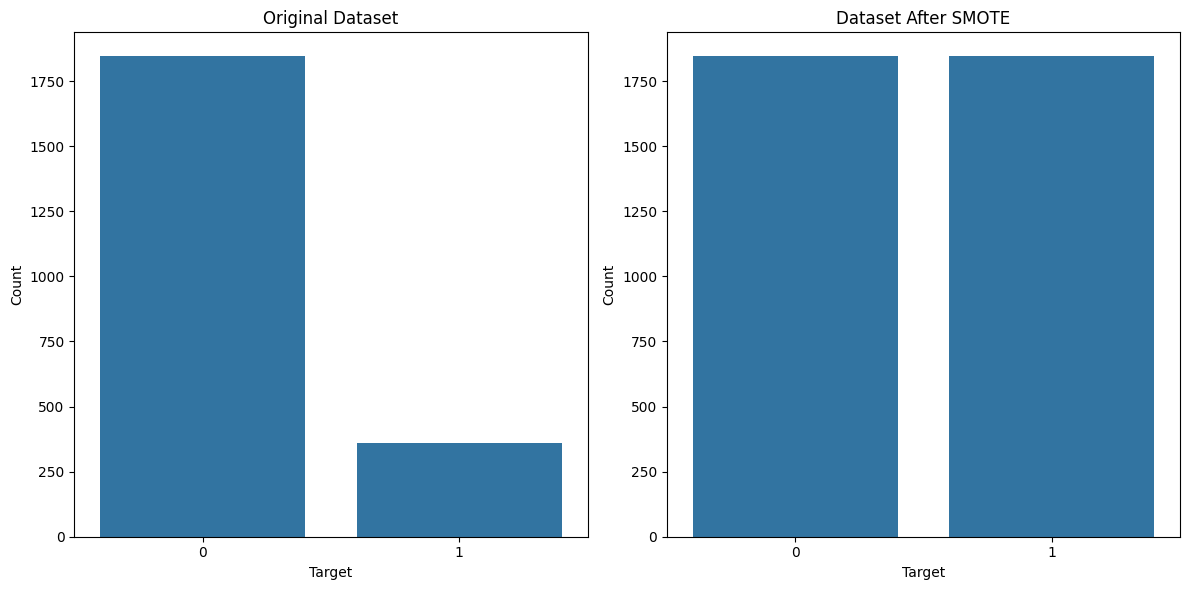

In [103]:
X_train, X_test, y_train, y_test = manual_split(df1, target_column=target)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Plot the dataset before and after SMOTE
plot_dataset_before_after_smote(X_train, y_train, X_resampled, y_resampled)


In [104]:
# Convert the resampled X and y arrays into a DataFrame
resampled_df = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame({'y': y_resampled})], axis=1)

# Export the DataFrame to a CSV file
resampled_df.to_csv('Customer_Churn_resampled_dataset.csv', index=False)


## Random Forest (Data Technique)

In [117]:
def model_selection():
    model = RandomForestClassifier()  
    print('Random Forest Classifier')  
    return model

In [106]:
master_pipeline_with_smote(filepath, target)

Random Forest Classifier

Training model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.826
F1 -ve: 0.968
AUC: 0.980
Accuracy: 0.946

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.966
Fold 2: 0.972
Fold 3: 0.973
Fold 4: 0.972
Fold 5: 0.974

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.848
F1 -ve: 0.973
AUC: 0.979
Accuracy: 0.953


## Gradient Boosting (Data Technique)

In [115]:

def model_selection():
    model = GradientBoostingClassifier()   
    print('Gradient Boosting Classifier')  
    return model

In [108]:
master_pipeline_with_smote(filepath, target)

Gradient Boosting Classifier

Training model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.757
F1 -ve: 0.947
AUC: 0.974
Accuracy: 0.913

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.942
Fold 2: 0.932
Fold 3: 0.940
Fold 4: 0.944
Fold 5: 0.930

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.760
F1 -ve: 0.948
AUC: 0.974
Accuracy: 0.914


## Naive Bayes (Data Technique)

In [116]:

def model_selection():
    model = GaussianNB()  
    print('Naive Bayes')  
    return model

In [110]:
master_pipeline_with_smote(filepath, target)

Naive Bayes

Training model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.447
F1 -ve: 0.765
AUC: 0.893
Accuracy: 0.670

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.791
Fold 2: 0.786
Fold 3: 0.797
Fold 4: 0.795
Fold 5: 0.782

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.447
F1 -ve: 0.765
AUC: 0.893
Accuracy: 0.670


## Logistic Regression (Data Technique)

In [111]:

def model_selection():
    model = LogisticRegression(max_iter=1000000)  
    print('Logistic Regression') 
    return model

In [112]:
master_pipeline_with_smote(filepath, target)

Logistic Regression

Training model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.559
F1 -ve: 0.879
AUC: 0.918
Accuracy: 0.810

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.844
Fold 2: 0.860
Fold 3: 0.851
Fold 4: 0.839
Fold 5: 0.837

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.559
F1 -ve: 0.879
AUC: 0.918
Accuracy: 0.810


## Decision Trees (Data Technique)

In [113]:

def model_selection():
    model = DecisionTreeClassifier()  
    print('Decision Tree Classifier') 
    return model

In [114]:
master_pipeline_with_smote(filepath, target)

Decision Tree Classifier

Training model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.761
F1 -ve: 0.955
AUC: 0.894
Accuracy: 0.925

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.940
Fold 2: 0.951
Fold 3: 0.954
Fold 4: 0.958
Fold 5: 0.955

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.770
F1 -ve: 0.957
AUC: 0.899
Accuracy: 0.928


## Results

### Class Imbalance - (Data Technique)
|          | Logistic Regression | Naïve Bayes | Decision Tree | Random Forest Classifier | Gradient Boosting |
|------------------------|---------------------|-------------|---------------|--------------------------|-------------------|
| F1 +ve                 | 0.559               | 0.447       | 0.770         | 0.848                    | 0.760             |
| F1-ve                  | 0.879               | 0.765       | 0.957         | 0.973                    | 0.948             |
| AUC                    | 0.918               | 0.893       | 0.899         | 0.979                    | 0.974             |
| Accuracy               | 0.810               | 0.670       | 0.928         | 0.953                    | 0.914             |


# 1